# SPX $g$-Pricing 

In [1]:
import sys
import pickle
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm
from scipy import spatial, interpolate
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d
np.random.seed(1)
tf.set_random_seed(1)

## Forward-Backward Stochastic Differential Equations
\begin{align}
  &X_t = X_0 + \int_0^t rX_s ~\text{d}s + \int_0^t \sigma(s, X_s) ~\text{d} W_s, \\
  &Y_t = \phi(X_T,K) + \int_t^T g(s, X_s, Y_s, Z_s) ~\text{d} s - \int_t^T Z_s ~\text{d} W_s. 
\end{align}
For _European call options_, the terminal condition $\phi_c(X_T, K) = (X_T-K)^+$; For _European put options_, the terminal condition $\phi_p(X_T, K) = (K - X_T)^+$. 

In [2]:
# Parameters: 
N = 16   # Time-Steps
I = 128  # minibatch size
M = 32   # number of trajectories

In [48]:
# Read Raw Data:
idata = pd.read_csv("BS-Sample-0.15.csv", encoding="utf8")
idata["mid(C)"] = (idata["bid(C)"] + idata["ask(C)"]) / 2
idata["mid(P)"] = (idata["bid(P)"] + idata["ask(P)"]) / 2
idata = idata[(idata["Y(P)"] >= 0.01) & (idata["Y(C)"] >= 0.01)]

In [49]:
# Training & Validation: 
idata_train = idata[idata["date"] < "2020-12-01"]
idata_valid = idata[idata["date"] >= "2020-12-01"]
del idata_train["date"]
del idata_valid["date"]

In [50]:
idata_train

,tau,K,S,bid(C),ask(C),bid(P),ask(P),Y(C),Z(C),Y(P),Z(P),mid(C),mid(P)
200,0.0411,3060,3381,322.1,325.9,5.6,5.8,323.526381,506.923900,0.012095,-0.226100,324.00,5.70
201,0.0411,3065,3381,316.8,321.1,5.8,6.1,318.533224,506.876289,0.014829,-0.273711,318.95,5.95
202,0.0411,3070,3381,312.1,316.1,6.0,6.3,313.540632,506.819647,0.018129,-0.330353,314.10,6.15
203,0.0411,3075,3381,307.3,311.6,6.3,6.5,308.548711,506.752473,0.022100,-0.397527,309.45,6.40
204,0.0411,3080,3381,302.6,306.9,6.5,6.8,303.557583,506.673059,0.026863,-0.476941,304.75,6.65
205,0.0411,3085,3381,297.8,302.2,6.8,7.1,298.567389,506.579465,0.032561,-0.570535,300.00,6.95
206,0.0411,3090,3381,293.6,297.4,7.1,7.3,293.578292,506.469505,0.039356,-0.680495,295.50,7.20
207,0.0411,3095,3381,288.9,292.5,7.4,7.6,288.590481,506.340713,0.047437,-0.809287,290.70,7.50
208,0.0411,3100,3381,283.7,287.7,7.7,7.9,283.604171,506.190330,0.057018,-0.959670,285.70,7.80
209,0.0411,3105,3381,279.5,283.1,8.0,8.3,278.619608,506.015272,0.068346,-1.134728,281.30,8.15


In [9]:
def dense(name, prev_layer, num_units, is_training, reuse=False):
    layer = tf.layers.dense(prev_layer, num_units, use_bias=True, activation="relu", name=name, reuse=reuse)
    return layer

def dense_batch_norm(name, prev_layer, num_units, is_training, reuse=False):
    layer = tf.layers.dense(prev_layer, num_units, use_bias=False, activation=None, name=name+"-dense", reuse=reuse) # , kernel_initializer=tf.initializers.variance_scaling()
    layer = tf.layers.batch_normalization(layer, training=is_training, name=name+"-batchnorm", reuse=reuse)
    layer = tf.nn.tanh(layer)
    return layer

In [11]:
# Define Network: 
def network_sigma(_t, _Xt): 
    return 0.25 * tf.pow(_Xt, - 0.05 + 1.)

def network_g(_t, _Xt, _Yt, _Zt): 
    with tf.variable_scope("Lock-NET-g", reuse=tf.AUTO_REUSE): 
        _h_t = dense("H-t", tf.tile(_t,[1,M,1]), 50, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h_X = dense("H-X", _Xt, 50, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h_Y = dense("H-Y", _Yt, 50, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h_Z = dense("H-Z", _Zt, 50, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h = tf.concat([_h_t, _h_X, _h_Y, _h_Z], axis=-1)
        _h = dense("H2", _h, 256, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h = dense("H3", _h, 256, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h = dense("H4", _h, 256, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h = dense("H5", _h, 128, is_training=is_training, reuse=tf.AUTO_REUSE)
        _output = tf.layers.dense(_h, units=1, activation=None, name="G", reuse=tf.AUTO_REUSE)
    return _output

def network_Z(typ, _t, _Xt, _K, _T): 
    with tf.variable_scope("Lock-%s-NET-Z"%typ, reuse=tf.AUTO_REUSE): 
        _h_t = dense("H-t", tf.tile(_t,[1,M,1]), 50, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h_X = dense("H-X", _Xt, 50, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h_K = dense("H-K", tf.tile(_K,[1,M,1]), 50, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h_T = dense("H-T", tf.tile(_T,[1,M,1]), 50, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h = tf.concat([_h_t, _h_X, _h_K, _h_T], axis=-1)
        _h = dense("H2", _h, 256, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h = dense("H3", _h, 256, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h = dense("H4", _h, 256, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h = dense("H5", _h, 128, is_training=is_training, reuse=tf.AUTO_REUSE)
        _output = tf.layers.dense(_h, units=1, activation=None, name="Z", reuse=tf.AUTO_REUSE)
    return _output

def network_U(typ, _t, _Xt, _K, _T): 
    with tf.variable_scope("Lock-%s-NET-U"%typ, reuse=tf.AUTO_REUSE): 
        _h_t = dense("H-t", tf.tile(_t,[1,M,1]), 50, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h_X = dense("H-X", _Xt, 50, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h_K = dense("H-K", tf.tile(_K,[1,M,1]), 50, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h_T = dense("H-T", tf.tile(_T,[1,M,1]), 50, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h = tf.concat([_h_t, _h_X, _h_K, _h_T], axis=-1)
        _h = dense("H2", _h, 256, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h = dense("H3", _h, 256, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h = dense("H4", _h, 256, is_training=is_training, reuse=tf.AUTO_REUSE)
        _h = dense("H5", _h, 128, is_training=is_training, reuse=tf.AUTO_REUSE)
        _output = tf.layers.dense(_h, units=1, activation=None, name="U", reuse=tf.AUTO_REUSE)
    return _output

In [13]:
# Define Brownian motions (standard normal variable, not scaled): 
_dws = [tf.placeholder(tf.float32, [None,M,1], name="ph_dw_%.0f"%n) for n in range(N)]  # I x M x 1 (x N)

# Define strikes, time-to-maturity & time intervals (varying in a mini-batch): 
_K_c_ask = tf.placeholder(tf.float32, [None,1,1], name="ph_K-C-ASK")  # I x 1 x 1
_K_p_ask = tf.placeholder(tf.float32, [None,1,1], name="ph_K-P-ASK")  # I x 1 x 1
_T_c_ask = tf.placeholder(tf.float32, [None,1,1], name="ph_T-C-ASK")  # I x 1 x 1
_T_p_ask = tf.placeholder(tf.float32, [None,1,1], name="ph_T-P-ASK")  # I x 1 x 1
_dt_c_ask = _T_c_ask / N                                      # I x 1 x 1
_dt_p_ask = _T_p_ask / N                                      # I x 1 x 1

# Define a training signal: 
is_training = tf.placeholder(tf.bool, name="ph_is_training") 

# The forward SDE: 
_X0_c_ask = tf.placeholder(tf.float32, [None,1], name="ph_X0_c_ask")     # I x 1
_X0_p_ask = tf.placeholder(tf.float32, [None,1], name="ph_X0_p_ask")     # I x 1
_ts_c_ask = [n * _dt_c_ask for n in range(N+1)]                          # I x 1 x 1 (x N+1)
_ts_p_ask = [n * _dt_p_ask for n in range(N+1)]                          # I x 1 x 1 (x N+1)
_Xs_c_ask = [tf.tile(tf.reshape(_X0_c_ask, [-1,1,1]), [1,M,1])]    # I x M x 1 (x N+1)
_Xs_p_ask = [tf.tile(tf.reshape(_X0_p_ask, [-1,1,1]), [1,M,1])]    # I x M x 1 (x N+1)
_Ys_c_ask = []                               # I x M x 1 (x N+1)
_Ys_p_ask = []                               # I x M x 1 (x N+1)
_Zs_c_ask = []                               # I x M x 1 (x N)
_Zs_p_ask = []                               # I x M x 1 (x N)
_Us_c_ask = []                               # I x M x 1 (x N)
_Us_p_ask = []                               # I x M x 1 (x N)
_sigma_c_ask = []
_sigma_p_ask = []
for n in range(N): 
    _cur_t_c_ask = _ts_c_ask[n]   # I x 1 x 1
    _cur_t_p_ask = _ts_p_ask[n]   # I x 1 x 1
    _cur_X_c_ask = _Xs_c_ask[n]   # I x M x 1
    _cur_X_p_ask = _Xs_p_ask[n]   # I x M x 1
    _cur_sigma_c_ask = network_sigma(_cur_t_c_ask, _cur_X_c_ask)
    _cur_sigma_p_ask = network_sigma(_cur_t_p_ask, _cur_X_p_ask)
    _nxt_X_c_ask = _cur_X_c_ask + _cur_sigma_c_ask * tf.sqrt(_dt_c_ask) * _dws[n]
    _nxt_X_p_ask = _cur_X_p_ask + _cur_sigma_p_ask * tf.sqrt(_dt_p_ask) * _dws[n]
    _Xs_c_ask.append(_nxt_X_c_ask)
    _Xs_p_ask.append(_nxt_X_p_ask)
    _Ys_c_ask.append(np.nan)
    _Ys_p_ask.append(np.nan)
    _cur_U_c_ask = network_U("C-ASK", _cur_t_c_ask, _cur_X_c_ask, _K_c_ask, _T_c_ask)
    _cur_U_p_ask = network_U("P-ASK", _cur_t_p_ask, _cur_X_p_ask, _K_p_ask, _T_p_ask)
    _cur_Z_c_ask = network_Z("C-ASK", _cur_t_c_ask, _cur_X_c_ask, _K_c_ask, _T_c_ask)
    _cur_Z_p_ask = network_Z("P-ASK", _cur_t_p_ask, _cur_X_p_ask, _K_p_ask, _T_p_ask)
    _Us_c_ask.append(_cur_U_c_ask)
    _Us_p_ask.append(_cur_U_p_ask)
    _Zs_c_ask.append(_cur_Z_c_ask)
    _Zs_p_ask.append(_cur_Z_p_ask)
    _sigma_c_ask.append(_cur_sigma_c_ask)
    _sigma_p_ask.append(_cur_sigma_p_ask)

# The backward SDE: 
_loss_UY_c_ask = 0.
_loss_UY_p_ask = 0.
_loss_DYZ_c_ask = 0.
_loss_DYZ_p_ask = 0.
_Ys_c_ask.append(tf.maximum(_Xs_c_ask[N] - _K_c_ask, 0.))    # I x M x 1 (x N+1)
_Ys_p_ask.append(tf.maximum(_K_p_ask - _Xs_p_ask[N], 0.))    # I x M x 1 (x N+1)
for n in range(N-1, -1, -1): 
    _cur_t_c_ask = _ts_c_ask[n]   # I x 1 x 1
    _cur_t_p_ask = _ts_p_ask[n]   # I x 1 x 1
    _cur_X_c_ask = _Xs_c_ask[n]   # I x M x 1
    _cur_X_p_ask = _Xs_p_ask[n]   # I x M x 1
    _cur_U_c_ask = _Us_c_ask[n]   # I x M x 1
    _cur_U_p_ask = _Us_p_ask[n]   # I x M x 1
    _cur_Z_c_ask = _Zs_c_ask[n]   # I x M x 1
    _cur_Z_p_ask = _Zs_p_ask[n]   # I x M x 1
    _cur_Y_c_ask = _Ys_c_ask[n+1] + network_g(
        _cur_t_c_ask, _cur_X_c_ask, _cur_U_c_ask, _cur_Z_c_ask) * _dt_c_ask - \
        _cur_Z_c_ask * tf.sqrt(_dt_c_ask) * _dws[n]
    _cur_Y_p_ask = _Ys_p_ask[n+1] + network_g(
        _cur_t_p_ask, _cur_X_p_ask, _cur_U_p_ask, _cur_Z_p_ask) * _dt_p_ask - \
        _cur_Z_p_ask * tf.sqrt(_dt_p_ask) * _dws[n]
    _Ys_c_ask[n] = _cur_Y_c_ask
    _Ys_p_ask[n] = _cur_Y_p_ask
    
    _loss_UY_c_ask += tf.reduce_mean(tf.square(_cur_Y_c_ask - _cur_U_c_ask) / N)  # + tf.square(1/_cur_Y_c_ask - 1/_cur_U_c_ask)
    _loss_UY_p_ask += tf.reduce_mean(tf.square(_cur_Y_p_ask - _cur_U_p_ask) / N)  # + tf.square(1/_cur_Y_p_ask - 1/_cur_U_p_ask)
    
    _grad_sigma_c_ask = tf.gradients(_cur_U_c_ask, _cur_X_c_ask)[0] * _sigma_c_ask[n]
    _grad_sigma_p_ask = tf.gradients(_cur_U_p_ask, _cur_X_p_ask)[0] * _sigma_p_ask[n]
    _loss_DYZ_c_ask += tf.reduce_mean(tf.square(_cur_Z_c_ask - _grad_sigma_c_ask) / N)  # + tf.square(1/_cur_Z_c_ask - 1/_grad_sigma_c_ask)
    _loss_DYZ_p_ask += tf.reduce_mean(tf.square(_cur_Z_p_ask - _grad_sigma_p_ask) / N)  # + tf.square(1/_cur_Z_p_ask - 1/_grad_sigma_p_ask)

# Pricing Loss: 
_true_Y0_c_ask = tf.placeholder(tf.float32, [None,1], name="ph_Y0_c_ask")  # I x 1
_true_Y0_p_ask = tf.placeholder(tf.float32, [None,1], name="ph_Y0_p_ask")  # I x 1
_Y0_c_ask = tf.reduce_mean(_Ys_c_ask[0], axis=1, keepdims=False)           # I x 1
_Y0_p_ask = tf.reduce_mean(_Ys_p_ask[0], axis=1, keepdims=False)           # I x 1
_Z0_c_ask = tf.reduce_mean(_Zs_c_ask[0], axis=1, keepdims=False)           # I x 1
_Z0_p_ask = tf.reduce_mean(_Zs_p_ask[0], axis=1, keepdims=False)           # I x 1
_U0_c_ask = tf.reduce_mean(_Us_c_ask[0], axis=1, keepdims=False)           # I x 1
_U0_p_ask = tf.reduce_mean(_Us_p_ask[0], axis=1, keepdims=False)           # I x 1

_mse_c_ask = tf.reduce_mean(tf.square(_Y0_c_ask - _true_Y0_c_ask))  # + tf.square(1/_Y0_c_ask - 1/_true_Y0_c_ask)
_mse_p_ask = tf.reduce_mean(tf.square(_Y0_p_ask - _true_Y0_p_ask))  # + tf.square(1/_Y0_p_ask - 1/_true_Y0_p_ask)
_mae_c_ask = tf.reduce_mean(tf.abs(_Y0_c_ask - _true_Y0_c_ask))
_mae_p_ask = tf.reduce_mean(tf.abs(_Y0_p_ask - _true_Y0_p_ask))
_mape_c_ask = tf.reduce_mean(tf.abs(_Y0_c_ask / _true_Y0_c_ask - 1))
_mape_p_ask = tf.reduce_mean(tf.abs(_Y0_p_ask / _true_Y0_p_ask - 1))

_loss_UY = (_loss_UY_c_ask + _loss_UY_p_ask) / 2
_loss_DYZ = (_loss_DYZ_c_ask + _loss_DYZ_p_ask) / 2

_mse = (_mse_c_ask + _mse_p_ask) / 2
_mae = (_mae_c_ask + _mae_p_ask) / 2
_mape = (_mape_c_ask + _mape_p_ask) / 2

_loss = _mse + 1.0 * _loss_UY + 1.0 * _loss_DYZ

In [16]:
for variable in tf.trainable_variables():
    print(variable)

<tf.Variable 'Lock-C-ASK-NET-U/H-t/kernel:0' shape=(1, 50) dtype=float32_ref>
<tf.Variable 'Lock-C-ASK-NET-U/H-t/bias:0' shape=(50,) dtype=float32_ref>
<tf.Variable 'Lock-C-ASK-NET-U/H-X/kernel:0' shape=(1, 50) dtype=float32_ref>
<tf.Variable 'Lock-C-ASK-NET-U/H-X/bias:0' shape=(50,) dtype=float32_ref>
<tf.Variable 'Lock-C-ASK-NET-U/H-K/kernel:0' shape=(1, 50) dtype=float32_ref>
<tf.Variable 'Lock-C-ASK-NET-U/H-K/bias:0' shape=(50,) dtype=float32_ref>
<tf.Variable 'Lock-C-ASK-NET-U/H-T/kernel_1:0' shape=(1, 50) dtype=float32_ref>
<tf.Variable 'Lock-C-ASK-NET-U/H-T/bias_1:0' shape=(50,) dtype=float32_ref>
<tf.Variable 'Lock-C-ASK-NET-U/H2/kernel:0' shape=(200, 256) dtype=float32_ref>
<tf.Variable 'Lock-C-ASK-NET-U/H2/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'Lock-C-ASK-NET-U/H3/kernel:0' shape=(256, 256) dtype=float32_ref>
<tf.Variable 'Lock-C-ASK-NET-U/H3/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'Lock-C-ASK-NET-U/H4/kernel:0' shape=(256, 256) dtype=float32_ref>


In [17]:
global_step = tf.Variable(0, name='global_step', trainable=False)
boundaries = [5000, 10000]
learing_rates = [4e-3, 4e-4, 4e-5]
learing_rate = tf.train.piecewise_constant(global_step, boundaries=boundaries, values=learing_rates)

train_loss = tf.train.AdamOptimizer(learing_rate).minimize(_loss, global_step=global_step)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

print("Ready...")
pretime = datetime.datetime.today()

train_losses = []
train_mapes = []
train_mses = []
train_maes = []
valid_losses = []
valid_mapes = []
valid_mses = []
valid_maes = []
dtimes = []

# 'tau', 'K', 'S', 'bid(C)', 'ask(C)', 'bid(P)', 'ask(P)', 'Y(C)', 'Z(C)', 'Y(P)', 'Z(P)', 'mid(C)', 'mid(P)'
#  0.     1.   2.   3.        4.        5.        6.        7.      8.      9.      10      11        12
train = np.array(idata_train)
valid = np.array(idata_valid)

# Training: 
print("Training...")
for epoch in range(10001): 
    
    train_c = train.copy()
    train_p = train.copy()
    np.random.shuffle(train_c)
    np.random.shuffle(train_p)
    
    for i in range(0, len(train), I): 
        
        curdata_c = train_c[i:i+I, :]
        curdata_p = train_p[i:i+I, :]
        if (len(curdata_c) < I): 
            break
        
        dws = [np.random.normal(0., 1., (I,M,1)) for n in range(N)]
        X0_c = curdata_c[:,2].reshape([I,1])
        X0_p = curdata_p[:,2].reshape([I,1])
        K_c = curdata_c[:,1].reshape([I,1,1])
        K_p = curdata_p[:,1].reshape([I,1,1])
        T_c = curdata_c[:,0].reshape([I,1,1])
        T_p = curdata_p[:,0].reshape([I,1,1])
        true_Y0_c_ask = curdata_c[:,11].reshape([I,1])
        true_Y0_c_bid = curdata_c[:,11].reshape([I,1])
        true_Y0_p_ask = curdata_p[:,12].reshape([I,1])
        true_Y0_p_bid = curdata_p[:,12].reshape([I,1])
        
        feed_dict = {tensor: value 
            for value, tensor 
            in zip(dws+[X0_c,X0_p,true_Y0_c_ask,true_Y0_p_ask,K_c,K_p,T_c,T_p], 
                   _dws+[_X0_c_ask,_X0_p_ask,_true_Y0_c_ask,_true_Y0_p_ask,_K_c_ask,_K_p_ask,_T_c_ask,_T_p_ask])}
        feed_dict[is_training] = True
        
        curstep, _, lr, loss, curmse, curmae, curmape, curUYloss, curDYZloss = sess.run(
            [global_step, train_loss, learing_rate, 
             _loss, _mse, _mae, _mape, _loss_UY, _loss_DYZ], 
            feed_dict=feed_dict)
        
        if (curstep-1) % 50 == 0: 
            train_losses.append(loss)
            train_mapes.append(curmape)
            train_mses.append(curmse)
            train_maes.append(curmae)
            
            # Print
            sim_Y0_c_ask, sim_Y0_p_ask, sim_Z0_c_ask, sim_Z0_p_ask, sim_U0_c_ask, sim_U0_p_ask = sess.run(
                [_Y0_c_ask, _Y0_p_ask, _Z0_c_ask, _Z0_p_ask, _U0_c_ask, _U0_p_ask], 
                feed_dict=feed_dict)
            print("sim_Y0_c_ask:", sim_Y0_c_ask.reshape([-1])[0], 
                  "sim_U0_c_ask:", sim_U0_c_ask.reshape([-1])[0], 
                  "true_Y0_c_ask:", true_Y0_c_ask.reshape([-1])[0], 
                  "sim_Y0_p_ask:", sim_Y0_p_ask.reshape([-1])[0], 
                  "sim_U0_p_ask:", sim_U0_p_ask.reshape([-1])[0], 
                  "true_Y0_p_ask:", true_Y0_p_ask.reshape([-1])[0], 
                  "sim_Z0_c_ask:", sim_Z0_c_ask.reshape([-1])[0], 
                  "sim_Z0_p_ask:", sim_Z0_p_ask.reshape([-1])[0], 
            )

            print("[Train] Epoch %d Step %d, lr(%.6f): loss=%.4f, mse=%.4f, mae=%.4f, mape=%.4f, UY-loss=%.4f, DYZ-loss=%.4f" % (
                epoch, curstep, lr, loss, curmse, curmae, curmape, curUYloss, curDYZloss))
            
            curdata_c = valid[np.random.choice(len(valid), I), :]
            curdata_p = valid[np.random.choice(len(valid), I), :]
            
            dws = [np.random.normal(0., 1., (I,M,1)) for n in range(N)]
            X0_c = curdata_c[:,2].reshape([I,1])
            X0_p = curdata_p[:,2].reshape([I,1])
            K_c = curdata_c[:,1].reshape([I,1,1])
            K_p = curdata_p[:,1].reshape([I,1,1])
            T_c = curdata_c[:,0].reshape([I,1,1])
            T_p = curdata_p[:,0].reshape([I,1,1])
            true_Y0_c_ask = curdata_c[:,11].reshape([I,1])
            true_Y0_c_bid = curdata_c[:,11].reshape([I,1])
            true_Y0_p_ask = curdata_p[:,12].reshape([I,1])
            true_Y0_p_bid = curdata_p[:,12].reshape([I,1])

            feed_dict = {tensor: value 
                for value, tensor 
                in zip(dws+[X0_c,X0_p,true_Y0_c_ask,true_Y0_p_ask,K_c,K_p,T_c,T_p], 
                       _dws+[_X0_c_ask,_X0_p_ask,_true_Y0_c_ask,_true_Y0_p_ask,_K_c_ask,_K_p_ask,_T_c_ask,_T_p_ask])}
            feed_dict[is_training] = True
            loss, curmse, curmae, curmape, curUYloss, curDYZloss = sess.run(
                [_loss, _mse, _mae, _mape, _loss_UY, _loss_DYZ], 
                feed_dict=feed_dict)
            
            print("[Valid] Epoch %d Step %d, lr(%.6f): loss=%.4f, mse=%.4f, mae=%.4f, mape=%.4f, UY-loss=%.4f, DYZ-loss=%.4f" % (
                epoch, curstep, lr, loss, curmse, curmae, curmape, curUYloss, curDYZloss))
            
            valid_losses.append(loss)
            valid_mapes.append(curmape)
            valid_mses.append(curmse)
            valid_maes.append(curmae)
            
    if curstep > 2 * boundaries[-1] - boundaries[-2]: 
        break

Ready...
Training...
sim_Y0_c_ask: 70.63745 sim_U0_c_ask: 1325.61 true_Y0_c_ask: 204.25 sim_Y0_p_ask: 15.892092 sim_U0_p_ask: 795.598 true_Y0_p_ask: 23.85 sim_Z0_c_ask: 1250.7948 sim_Z0_p_ask: 981.6931
[Train] Epoch 0 Step 1, lr(0.004000): loss=315891.6562, mse=7331.0264, mae=66.9594, mape=0.7504, UY-loss=295841.2812, DYZ-loss=12719.3447
[Valid] Epoch 0 Step 1, lr(0.004000): loss=4161028.2500, mse=809832.5625, mae=629.3422, mape=11.6410, UY-loss=2113054.0000, DYZ-loss=1238141.7500
sim_Y0_c_ask: 46.646324 sim_U0_c_ask: 28.159567 true_Y0_c_ask: 25.6 sim_Y0_p_ask: 281.0143 sim_U0_p_ask: 524.06134 true_Y0_p_ask: 287.95 sim_Z0_c_ask: 135.97139 sim_Z0_p_ask: -314.60553
[Train] Epoch 0 Step 51, lr(0.004000): loss=20819.1602, mse=1491.3645, mae=29.2953, mape=0.7533, UY-loss=9805.1074, DYZ-loss=9522.6895
[Valid] Epoch 0 Step 51, lr(0.004000): loss=27111.9355, mse=992.1058, mae=22.7821, mape=0.6623, UY-loss=18766.4570, DYZ-loss=7353.3730
sim_Y0_c_ask: 89.91788 sim_U0_c_ask: 52.523724 true_Y0_c_a

In [18]:
# Save the trained model: 
dirpath = "./gPricing-(N=%d)" % N
saver = tf.train.Saver()
savpth = saver.save(sess, '%s/model' % dirpath)
curtime = pd.to_datetime(
    pd.datetime.utcnow(), utc=True).tz_convert('Asia/Shanghai')
logs = "[%s] The model is saved to: %s" % (
    curtime.strftime("%Y-%m-%d %H:%M:%S"), savpth)
print(logs)

[2022-04-05 15:10:21] The model is saved to: ./gPricing-(N=16)/model


In [19]:
# Save the training results: 
traindata = pd.DataFrame(index=np.arange(0,len(train_losses)*50,50))
traindata["train_losses"] = train_losses
traindata["train_mapes"] = train_mapes
traindata["train_mses"] = train_mses
traindata["train_maes"] = train_maes
traindata["valid_losses"] = valid_losses
traindata["valid_mapes"] = valid_mapes
traindata["valid_mses"] = valid_mses
traindata["valid_maes"] = valid_maes
traindata.to_csv("%s/Training-STATS-BS-(N=%d).csv"%(dirpath,N), encoding="utf8")

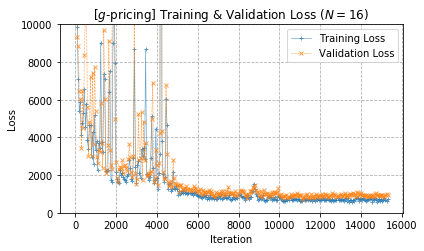

In [35]:
# Loss
fig = plt.figure(figsize=[6,3.6])
plt.plot(traindata["train_losses"][0::1], label=r"Training Loss", 
         alpha=0.7, linewidth=0.6, marker="+", markersize=4, linestyle="-")
plt.plot(traindata["valid_losses"][0::1], label=r"Validation Loss", 
         alpha=0.7, linewidth=0.6, marker="x", markersize=4, linestyle="--") 
plt.ylim([0, 10000])
# plt.xlim([0,40000])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title(r"[$g$-pricing] Training & Validation Loss ($N=%d$)"%N)
plt.legend()
plt.grid(linestyle='--')
plt.tight_layout()
plt.savefig("%s/fig-loss-gprice-(N=%d).pdf"%(dirpath,N), format="pdf", bbox_inches='tight', pad_inches=0.05)